In [2]:
# dependancies
import pandas as pd
import os
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'Arial'

In [3]:
# functions

def countTable_to_fractionDF(countTable):

    countDF = pd.DataFrame(countTable)
    countDF.drop(["sample"], axis=1, inplace=True)
    # Normalize each row by dividing by the sum of each row
    fractionDF = countDF.div(countDF.sum(axis=1), axis=0)
    # Add the sample column back in at the start
    sampleList = ["A_SR16s", "B_SR16s", "C_SR16s", "D_SR16s", "E_SR16s", "F_SR16s"]
    fractionDF.insert(0, "sample", sampleList)
    # Make a long form of the data, repeat same sample name for each sample and a new row for each genus
    fractionDF = fractionDF.melt(id_vars="sample", var_name="species", value_name="fraction")
    # Sort the DataFrame by sample and then genus
    fractionDF = fractionDF.sort_values(by=["sample", "species"])
    # remove any rows with fraction == 0 and reset the index
    fractionDF = fractionDF[fractionDF["fraction"] != 0].reset_index(drop=True)
    return fractionDF

### Get data

In [4]:
### ground truth ###

input_mock = {"sample": ["Ground_truth", "Ground_truth", "Ground_truth", "Ground_truth", "Ground_truth", "Ground_truth", "Ground_truth"],
    "fraction": [0.1111111111, 0.2222222222, 0.1111111111, 0.1111111111, 0.2222222222, 0.1111111111, 0.1111111111],
    "genus": ["Corynebacterium", "Corynebacterium", "Staphylococcus", "Staphylococcus", "Pseudomonas", "Klebsiella", "Moraxella"],
    "species": ["Corynebacterium tuberculostearicum", "Corynebacterium pseudodiphtheriticum",
                "Staphylococcus aureus", "Staphylococcus epidermidis", "Pseudomonas aeruginosa",
                "Klebsiella pneumoniae", "Moraxella catarrhalis"]
}

input_mock = pd.DataFrame(input_mock)

In [5]:
### SR 16s ###

# read in csv
genus_path_16s = "profiled_data/SR_16s/genus_level_6_silva.csv"
spp_path_16s = "profiled_data/SR_16s/spp_level_7_silva.csv"

# clean data
genus_16s = pd.read_csv(genus_path_16s)
spp_16s = pd.read_csv(spp_path_16s)

genus_16s.drop(["mock"], axis=1, inplace=True)
spp_16s.drop(["mock"], axis=1, inplace=True)

spp_16s["Moraxella_spp"] = sum([spp_16s["Moraxella_spp1"], spp_16s["Moraxella_spp2"]])
spp_16s["unclassified"] = sum([spp_16s["unclassified1"], spp_16s["unclassified2"]])
spp_16s.drop(["Moraxella_spp1", "Moraxella_spp2", "unclassified1", "unclassified2"], axis=1, inplace=True)

df_16sSRspp_fraction = countTable_to_fractionDF(spp_16s)

spp_genus = {"Corynebacterium_propinquum": "Corynebacterium", "Corynebacterium_spp": "Corynebacterium", "Enterobacteriaceae_genera": "Enterobacteriaceae_genera", "Klebsiella_spp": "Klebsiella", 
             "Moraxella_spp": "Moraxella", "Staphylococcus_spp": "Staphylococcus", "Escherichia-Shigella_spp": "Escherichia-Shigella", "Corynebacteriaceae_genera": "Corynebacteriaceae_genera", 
             "Pseudomonas_spp": "Pseudomonas", "Klebsiella_pneumoniae": "Klebsiella", "Gammaproteobacteria_order": "Gammaproteobacteria_order", "unclassified": "unclassified"}

df_16sSRspp_fraction["genus"] = df_16sSRspp_fraction["species"].map(spp_genus)
df_16sSRspp_fraction = df_16sSRspp_fraction[['sample', 'fraction', 'genus', 'species']]

# normalise unclassified reads
classified_SR16s = df_16sSRspp_fraction.copy()
denominators = df_16sSRspp_fraction[df_16sSRspp_fraction['species'] != 'unclassified'].groupby('sample')['fraction'].sum().values
sampleList = ["A_SR16s", "B_SR16s", "C_SR16s", "D_SR16s", "E_SR16s", "F_SR16s"]
denominator_map = dict(zip(sampleList, denominators))
classified_SR16s['fraction'] = classified_SR16s['fraction'] / classified_SR16s['sample'].map(denominator_map)
classified_SR16s = classified_SR16s[classified_SR16s['species'] != 'unclassified']

check_sums = classified_SR16s[classified_SR16s['species'] != 'unclassified'].groupby('sample')['fraction'].sum().values
# print(check_sums)
# print(classified_SR16s)

In [6]:
### LR 16s ONT ###

# get data
path_16sONT = "profiled_data/LR16sONT"
file_names = sorted([f for f in os.listdir(path_16sONT) if f.endswith(".csv")])
ONT16s_df_list = []

for file_name in file_names:
    full_path = os.path.join(path_16sONT, file_name)
    
    if os.path.exists(full_path):
        with open(full_path, 'r') as file:
            df = pd.read_csv(StringIO(file.read()), sep=",", header=0)
            ONT16s_df_list.append(df)

# Remove the last row of each dataframe (unassigned all = 0)
for i, df in enumerate(ONT16s_df_list):
    ONT16s_df_list[i] = df.drop(df.tail(1).index)

# clean data
samples = ["A_LR16sONT", "B_LR16sONT", "C_LR16sONT", "D_LR16sONT", "E_LR16sONT", "F_LR16sONT"]

for i, df in enumerate(ONT16s_df_list):
    df.insert(0, "sample", samples[i])

classified_LR16sONT = pd.concat(ONT16s_df_list, ignore_index=True)
classified_LR16sONT.rename(columns={"abundance": "fraction"}, inplace=True)

In [7]:
### LR 16s KAPA ###

# get data
path_16sKAPA = "profiled_data/LR16sKAPA"
file_names = sorted([f for f in os.listdir(path_16sKAPA) if f.endswith(".csv")])
KAPA16s_df_list = []

for file_name in file_names:
    full_path = os.path.join(path_16sKAPA, file_name)
    
    if os.path.exists(full_path):
        with open(full_path, 'r') as file:
            df = pd.read_csv(StringIO(file.read()), sep=",", header=0)
            KAPA16s_df_list.append(df)

# no unassigned gdata

# clean data
samples = ["A_LR16sKAPA", "B_LR16sKAPA", "C_LR16sKAPA", "D_LR16sKAPA", "E_LR16sKAPA", "F_LR16sKAPA"]

for i, df in enumerate(KAPA16s_df_list):
    df.insert(0, "sample", samples[i])

classified_LR16sKAPA = pd.concat(KAPA16s_df_list, ignore_index=True)
classified_LR16sKAPA.rename(columns={"abundance": "fraction"}, inplace=True)

In [8]:
### SR shotgun ###

# get data
pathSR_shot = "profiled_data/SR_shotgun"
file_names = sorted([f for f in os.listdir(pathSR_shot) if f.endswith(".tsv")])
SRdf_list = []

for file_name in file_names:
    full_path = os.path.join(pathSR_shot, file_name)
    
    if os.path.exists(full_path):
        with open(full_path, 'r') as file:
            df = pd.read_csv(StringIO(file.read()), sep="\t", header=0)
            SRdf_list.append(df)

#  clean data and normalise unclassified reads
classified_SRdf_list = []
SRdf_list_copy = SRdf_list.copy()
mocks = ["A", "B", "C", "E", "F"]

for i, df in enumerate(SRdf_list_copy):
    sum_classified = df.loc[df['genus'] != 'unclassified', 'fraction'].sum()
    df['fraction'] = df['fraction'] / sum_classified
    classified_df = df[df['genus'] != 'unclassified']
    classified_df.insert(0, 'sample', f"{mocks[i]}_SRshot")
    classified_SRdf_list.append(classified_df)

classified_SRshotgun = pd.concat(classified_SRdf_list, ignore_index=True)

In [9]:
### SR shotgun no preprocessing ###

# get data
pathSR_nopre_shot = "profiled_data/SR_shotgun_noPreprocessing"
file_names = sorted([f for f in os.listdir(pathSR_nopre_shot) if f.endswith(".tsv")])
SR_nopre_df_list = []

for file_name in file_names:
    full_path = os.path.join(pathSR_nopre_shot, file_name)
    
    if os.path.exists(full_path):
        with open(full_path, 'r') as file:
            df = pd.read_csv(StringIO(file.read()), sep="\t", header=0)
            SR_nopre_df_list.append(df)

#  clean data and normalise unclassified reads
classified_SRdf_nopre_list = []
SR_nopredf_list_copy = SR_nopre_df_list.copy()
mocks = ["A", "B", "C", "E", "F"]

for i, df in enumerate(SR_nopredf_list_copy):
    sum_classified = df.loc[df['genus'] != 'unclassified', 'fraction'].sum()
    df['fraction'] = df['fraction'] / sum_classified
    classified_df = df[df['genus'] != 'unclassified']
    classified_df.insert(0, 'sample', f"{mocks[i]}_SRshot_noPre")
    classified_SRdf_nopre_list.append(classified_df)

classified_SRshotgun_noPre = pd.concat(classified_SRdf_nopre_list, ignore_index=True)

In [10]:
### LR shotgun ###

# get data
pathLR_shot = "profiled_data/LR_shotgun"
file_names = sorted([f for f in os.listdir(pathLR_shot) if f.endswith(".tsv")])
LRdf_list = []

for file_name in file_names:
    full_path = os.path.join(pathLR_shot, file_name)
    
    if os.path.exists(full_path):
        with open(full_path, 'r') as file:
            df = pd.read_csv(StringIO(file.read()), sep="\t", header=0)
            LRdf_list.append(df)

#  clean data and normalise unclassified reads
classified_LRdf_list = []
LRdf_list_copy = LRdf_list.copy()
mocks = ["A", "B", "C", "D", "E", "F"]

for i, df in enumerate(LRdf_list_copy):
    sum_classified = df.loc[df['genus'] != 'unclassified', 'fraction'].sum()
    df['fraction'] = df['fraction'] / sum_classified
    classified_df = df[df['genus'] != 'unclassified']
    classified_df.insert(0, 'sample', f"{mocks[i]}_LRshot")
    classified_LRdf_list.append(classified_df)

classified_LRshotgun = pd.concat(classified_LRdf_list, ignore_index=True)

In [11]:
### LR shotgun no preprocessing ###

# get data
pathLR_nopre_shot = "profiled_data/LR_shotgun_noPreprocessing"
file_names = sorted([f for f in os.listdir(pathLR_nopre_shot) if f.endswith(".tsv")])
LR_nopre_df_list = []

for file_name in file_names:
    full_path = os.path.join(pathLR_nopre_shot, file_name)
    
    if os.path.exists(full_path):
        with open(full_path, 'r') as file:
            df = pd.read_csv(StringIO(file.read()), sep="\t", header=0)
            LR_nopre_df_list.append(df)

#  clean data and normalise unclassified reads
classified_LRdf_nopre_list = []
LR_nopredf_list_copy = LR_nopre_df_list.copy()
mocks = ["A", "B", "C", "D", "E", "F"]

for i, df in enumerate(LR_nopredf_list_copy):
    sum_classified = df.loc[df['genus'] != 'unclassified', 'fraction'].sum()
    df['fraction'] = df['fraction'] / sum_classified
    classified_df = df[df['genus'] != 'unclassified']
    classified_df.insert(0, 'sample', f"{mocks[i]}_LRshot_noPre")
    classified_LRdf_nopre_list.append(classified_df)

classified_LRshotgun_noPre = pd.concat(classified_LRdf_nopre_list, ignore_index=True)

In [12]:
### final dataframes ###

# input_mock
# classified_SR16s
# classified_LR16sONT
# classified_LR16sKAPA
# classified_SRshotgun
# classified_SRshotgun_noPre
# classified_LRshotgun
# classified_LRshotgun_noPre

In [13]:
# merge all dataframes together
all_dfs = [input_mock, classified_SR16s, classified_LR16sONT, classified_LR16sKAPA, classified_SRshotgun, classified_SRshotgun_noPre, classified_LRshotgun, classified_LRshotgun_noPre]
all_dfs_merged = pd.concat(all_dfs, ignore_index=True)[['sample', 'fraction', 'genus', 'species']]

# clean data
all_dfs_merged['genus'] = all_dfs_merged['genus'].str.replace("g__", "").str.replace("_", " ")
all_dfs_merged['species'] = all_dfs_merged['species'].str.replace("s__", "").str.replace("_", " ")

### Assign Taxonomic Colour Map

In [14]:
# make colours dataframe

colours = {
    "grey": ["#3A3A3A", "#565656", "#6A6A6A", "#949494", "#B5B5B5", "#DCDCDC", "#EBEBEB", "#F3F3F3"], # Acinetobacter n=1
    "bluegrey": ["#303E45", "#3C5059", "#4A636F", "#557280", "#6C8591", "#849AA4", "#A7B6BD", "#C8D3D7"], # Bacillus A n=4
    "blue": ["#165AB8", "#186BCC", "#1C7DE1", "#1F8BF1", "#3A9BF3", "#58ACF6", "#85C3F8", "#B3DAFA"], # Clostridium n=1
    "cyan": ["#046CB5", "#047CCC", "#0790E1", "#079FF2", "#25ADF5", "#46BBF6", "#76CFF9", "#AAE1FC"], # Corynebacteriaceae n=1
    "teal": ["#007884", "#008C9D", "#00A2BA", "#00B4CF", "#22BFD6", "#44CADD", "#74D9E7", "#A9E8F0"], # Corynebacterium n=7
    "forest": ["#005D52", "#006D5F", "#007D6F", "#008B7C", "#229B8E", "#44ADA2", "#74C4BC", "#A9DAD6"], # Enterobacter n=1
    "darkgreen": ["#29722C", "#318335", "#3B963E", "#43A646", "#5BB35F", "#76C079", "#9BD09E", "#C1E3C2"], # Enterobacteriaceae n=1
    "red": ["#BF2524", "#CD2929", "#E2322F", "#F33B2F", "#ED4946", "#E16768", "#ED8F8F", "#FFC6CD"], # Escherichia n=1
    "violet": ["#5F1A8F", "#701D98", "#8221A0", "#9024A7", "#A13EB4", "#B15DC1", "#C788D4", "#DDB6E3"], # Escherichia-Shigella n=1
    "indigo": ["#252F87", "#2B3794", "#3240A1", "#3747AC", "#5260B9", "#6D7AC4", "#959ED5", "#BDC3E6"], # Gammaproteobacteria n=1
    "magenta": ["#D31A55", "#E71C57", "#EA376F", "#EE5787", "#F284A8", "#F7B3CA", "#A3144C", "#BA1751"], # Klebsiella n=5
    "bloodorange": ["#D33B19", "#E24118", "#F3471C", "#FF4D1F", "#FF653A", "#FF7F59", "#FFA186", "#FFC5B5"], # Laceyella n=1
    "purple": ["#5B33AE", "#724CBB", "#896AC6", "#AA92D6", "#3C2396", "#47289E", "#532FA8", "#CBBCE6"], # Moraxella n=4
    "brown": ["#452E29", "#533830", "#624339", "#6E4B3F", "#826358", "#977D73", "#B4A09A", "#D1C5C2"], # Mycobacterium n=1
    "green": ["#5C9531", "#70AA3A", "#80BC41", "#91C559", "#A4CF76", "#BDDD9B", "#D8EAC2", "#4A8029"], # Pseudomonas n=3
    "limegreen": ["#949221", "#A6AB26", "#B8C42D", "#C6D832", "#CEDE4D", "#D7E36A", "#E2EB91", "#EEF2BB"], # Pseudomonas E n=1
    "orange": [ "#ED6106", "#F37004", "#FA8006", "#FF8D04", "#FF9D22", "#FFAE44", "#FFC575", "#FFDDA9"], # Spirillospora n=1
    "yellow": ["#F89E21", "#FCB828", "#FDD32F", "#FFE934", "#FFED4D", "#FFEF6B", "#FEF392", "#FFF8BD"] # Staphylococcus n=7
}    

colours_df = pd.DataFrame(colours)

colourname_list = []
tint_list = []
for column_name in colours_df.columns:
    colourname_list.append(column_name)
    tint_list.append(colours_df[column_name].values)


In [15]:
# assign genus colours, add column to all_dfs_coloured

unique_genera = all_dfs_merged['genus'].unique()
unique_genera = sorted(unique_genera)

if len(tint_list) < len(unique_genera):
    raise ValueError("There are more unique genera than there are colours in the colour palette")

genus_colour_df = pd.DataFrame(columns=["genus", "colour name", "tints"])

for i in range(len(unique_genera)):
    genus_colour_df.loc[i] = [unique_genera[i], colourname_list[i], tint_list[i]]

genus_colour_df['genus_hex'] = genus_colour_df.apply(lambda x: x['tints'][0], axis=1)

all_profiles_coloured = all_dfs_merged.merge(genus_colour_df[['genus', 'genus_hex']], on='genus', how='left')

In [16]:
# assign species colours, add column to all_dfs_coloured

unique_species = all_dfs_merged['species'].unique()
unique_species = sorted(unique_species)

# work in df with unique species
unique_species_df = pd.DataFrame(columns=['genus', 'species'])
# Match the species to their genus
unique_species_df['species'] = unique_species
unique_species_df['genus'] = unique_species_df['species'].apply(lambda x: all_dfs_merged.loc[all_dfs_merged['species'] == x, 'genus'].values[0])
# Add colours by taxonomy
unique_species_df = unique_species_df.merge(genus_colour_df[['genus', 'colour name']], on='genus', how='left')
unique_species_df = unique_species_df.merge(genus_colour_df[['genus', 'genus_hex']], on='genus', how='left')
unique_species_df = unique_species_df.merge(genus_colour_df[['genus', 'tints']], on='genus', how='left')

# Initialize a new column for hex codes, initialize genus_matches as 0
unique_species_df['species_hex'] = ''
genus_matches = 0

# Iterate through each row
for i in range(len(unique_species_df)):
    tints_list = unique_species_df.iloc[i]['tints']
    value_to_add = tints_list[genus_matches]
    unique_species_df.at[i, 'species_hex'] = value_to_add

    # Check if it's not the last row to avoid an index out-of-range error
    if i < len(unique_species_df) - 1:
        current_genus = unique_species_df.iloc[i]['genus']
        next_genus = unique_species_df.iloc[i + 1]['genus']
        
        # Check if the genus of the current row matches the next row
        if current_genus == next_genus:
            # increment genus matches
            genus_matches += 1
        else:
            genus_matches = 0

# match the species_hex column to the merged df
all_profiles_coloured = all_profiles_coloured.merge(unique_species_df[['species', 'species_hex']], on='species', how='left')

In [17]:
# export for later use
all_profiles_coloured.to_csv("processed_data/all_profiles_coloured.csv", index=False)

# # read in
# all_profiles_coloured = pd.read_csv("all_profiles_coloured.csv")

### Transform data for stacked barchart

In [18]:
# colour maps
species_colour_map = unique_species_df.set_index('species')['species_hex'].to_dict()
genus_colour_map = unique_species_df.set_index('genus')['genus_hex'].to_dict()

In [19]:
# get data

all_df_list = []
for sample in all_profiles_coloured['sample'].unique():
    sample_df = all_profiles_coloured[all_profiles_coloured['sample'] == sample]
    all_df_list.append(sample_df)

# high qual data (not samples that have _noPre in the name)
high_qual_df_list = []
for df in all_df_list:
    if "_noPre" not in df['sample'].unique()[0]:
        high_qual_df_list.append(df)

In [20]:
### PREPARE SPECIES LEVEL DATA ###

# Create a DataFrame with the unique species as the index
sppDFplot = pd.DataFrame(index=unique_species)

# name the index column "species"
sppDFplot.index.name = "species"

# iterate through each df in final_df_list, name a column after the unique value in sample, and add the fraction to the sppDFplot DataFrame for the corresponding secies in the species column
for df in high_qual_df_list:
    sample = df['sample'].unique()[0]
    sppDFplot[sample] = df.set_index('species')['fraction']

# replace NaN with 0
sppDFplot.fillna(0, inplace=True)

# transpose
transposed_spp_data = sppDFplot.T

In [51]:
### FUNCTION TO PLOT SPECIES ###

def plot_stackedbar_spp(df, labels, color_map,
                        background_colour, plot_colour, font_colour, line_colour):
    fields = df.columns.tolist()
    
    # figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 10))
    
    # plot bars
    bottom = len(df) * [0]
    for idx, name in enumerate(fields):
        plt.bar(df.index, df[name], bottom=bottom, color=color_map[name], alpha=0.85, edgecolor='#FEF995', width=1, label=name)
        bottom = bottom + df[name]
    
    # legend
    plt.text(30.15, 1.0375, 'Species', fontsize=14, fontweight='bold', color=font_colour)
    legend = plt.legend(labels, bbox_to_anchor=([1.01, 1.03, 0, 0]), ncol=1, frameon=False)
    for text in legend.get_texts():
        text.set_color(font_colour)
        text.set_fontsize(11)
    
    # format y ticks
    yticks = np.arange(0, 1.1, 0.1)
    ylabels = ['{}%'.format(i) for i in np.arange(0, 101, 10)]
    plt.yticks(yticks, ylabels)

    # relabel x ticks
    plt.xticks(df.index, ["Truth", "A", "B", "C", "D", "E", "F",
               "A", "B", "C", "E", "F",
               "A", "B", "C", "D", "E", "F",
               "A", "B", "C", "D", "E", "F",
               "A", "B", "C", "D", "E", "F"])

    # # adjust limits and draw grid lines
    plt.xlim(-0.5, ax.get_xticks()[-1] + 0.5)

    # axes label colour and font
    ax.tick_params(axis='x', colors=line_colour)
    ax.tick_params(axis='y', colors=line_colour)

    for label in ax.get_xticklabels():
        label.set_fontsize(12)

    for label in ax.get_yticklabels():
        label.set_fontsize(12)

    # Rotate x-axis tick labels
    plt.xticks(rotation=0)

    # Grid params
    ax.set_facecolor(plot_colour)

    # Figure params
    figure = plt.gcf()
    figure.set_facecolor(background_colour)
    
    # horrizontal lines "#00A2BA", "#00B4CF"
    plt.axhline(y=0.221, color='#00B4CF', linestyle='--', linewidth=2)
    plt.axhline(y=0.332, color='#44CADD', linestyle='--', linewidth=2)
    plt.axhline(y=0.444, color='#E62C53', linestyle='--', linewidth=2)
    plt.axhline(y=0.555, color='#603EA1', linestyle='--', linewidth=2)
    plt.axhline(y=0.777, color='#619534', linestyle='--', linewidth=2)
    plt.axhline(y=0.888, color='#F79D27', linestyle='--', linewidth=2)
    # vertical lines
    plt.axvline(x=0.5, color=plot_colour, linestyle='-', linewidth=3)
    plt.axvline(x=6.5, color=plot_colour, linestyle='-', linewidth=3)
    plt.axvline(x=12.5, color=plot_colour, linestyle='-', linewidth=3)
    plt.axvline(x=18.5, color=plot_colour, linestyle='-', linewidth=3)
    plt.axvline(x=23.5, color=plot_colour, linestyle='-', linewidth=3)
    ax.spines['right'].set_color(line_colour)
    ax.spines['right'].set_linewidth(2)
    ax.spines['left'].set_color(line_colour)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_color(line_colour)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_color(line_colour)
    ax.spines['bottom'].set_linewidth(2)

    # title and labels
    plt.text(2.5, 1.06, 'Species Level Constitution of Mock Community', fontsize=22, fontweight='bold', color=font_colour)
    plt.text(7, 1.02, 'According to Sequencing Method', fontsize=22, fontstyle='italic', color=font_colour)
    figure.supxlabel('Mock Community Replicates A through F by Sequencing Method', color=font_colour, fontsize=14, y=0)
    ax.set_ylabel('Relative Abundance', color=font_colour, fontsize=16, fontweight='bold', labelpad=5)

    # x subtitles
    plt.text(0.5, -0.07, '|           SR 16s     ', fontsize=14, fontweight='bold', color=font_colour)
    plt.text(6.4, -0.07, '|      LR 16s (ONT)   ', fontsize=14, fontweight='bold', color=font_colour)
    plt.text(12.4, -0.07, '|     LR 16s (KAPA)  ', fontsize=14, fontweight='bold', color=font_colour)
    plt.text(18.4, -0.07, '|    SR shotgun  ', fontsize=14, fontweight='bold', color=font_colour)
    plt.text(23.4, -0.07, '|       LR shotgun       |', fontsize=14, fontweight='bold', color=font_colour)

    plt.show()

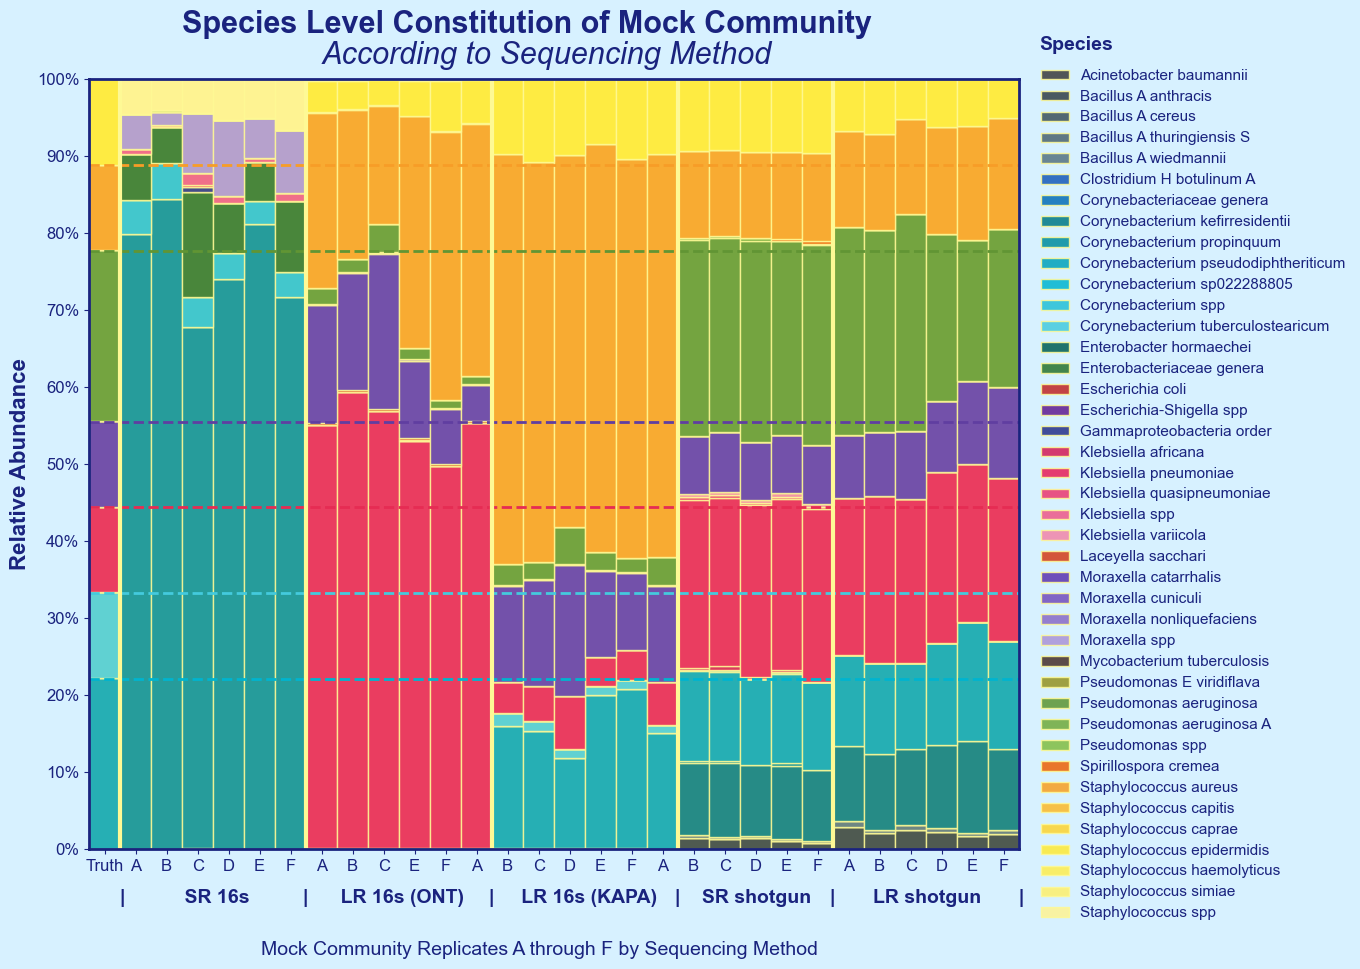

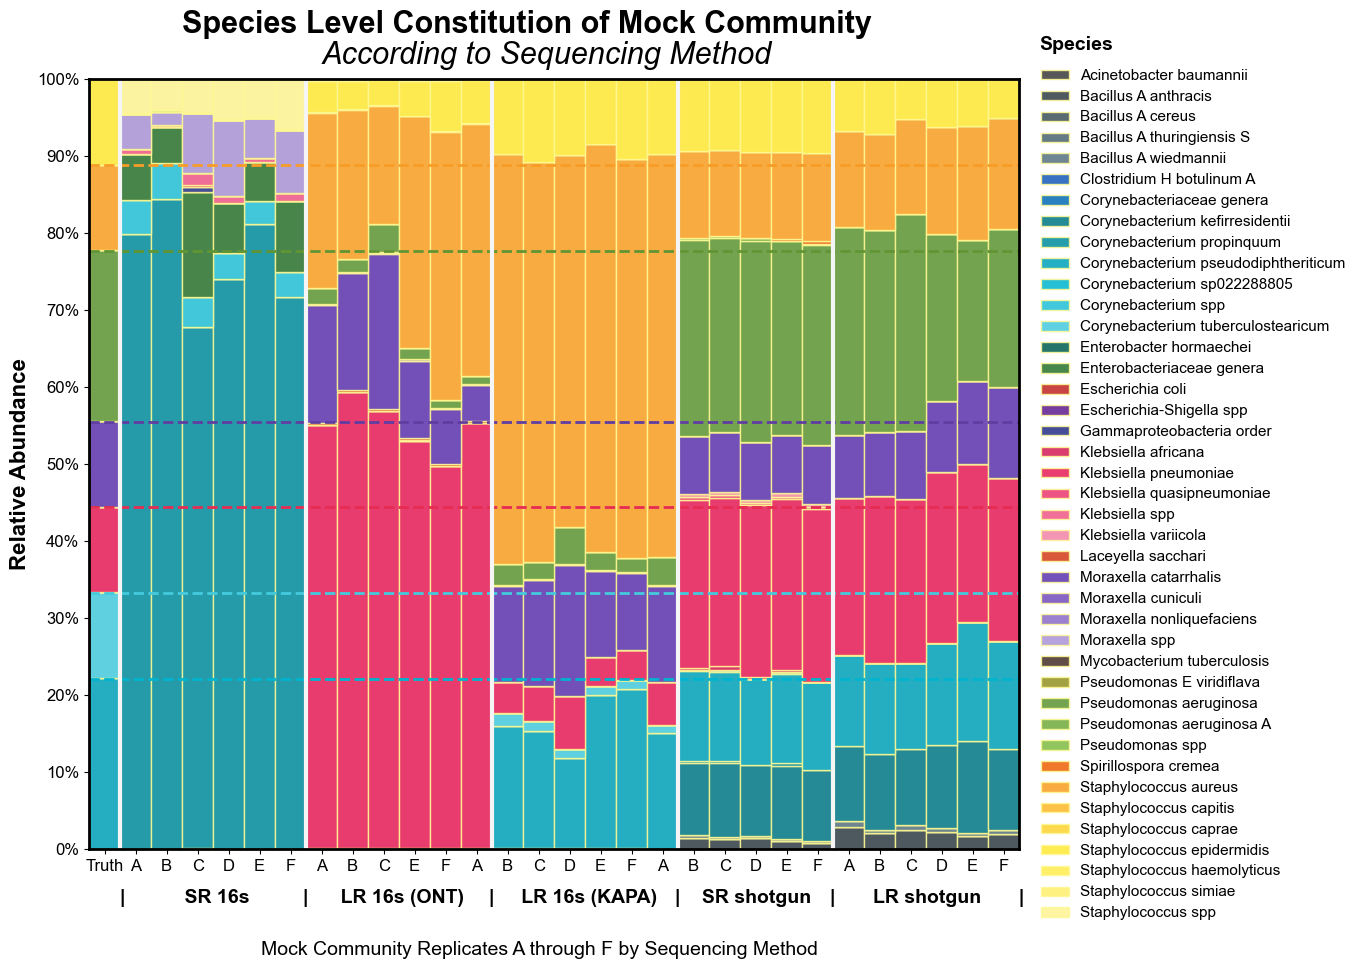

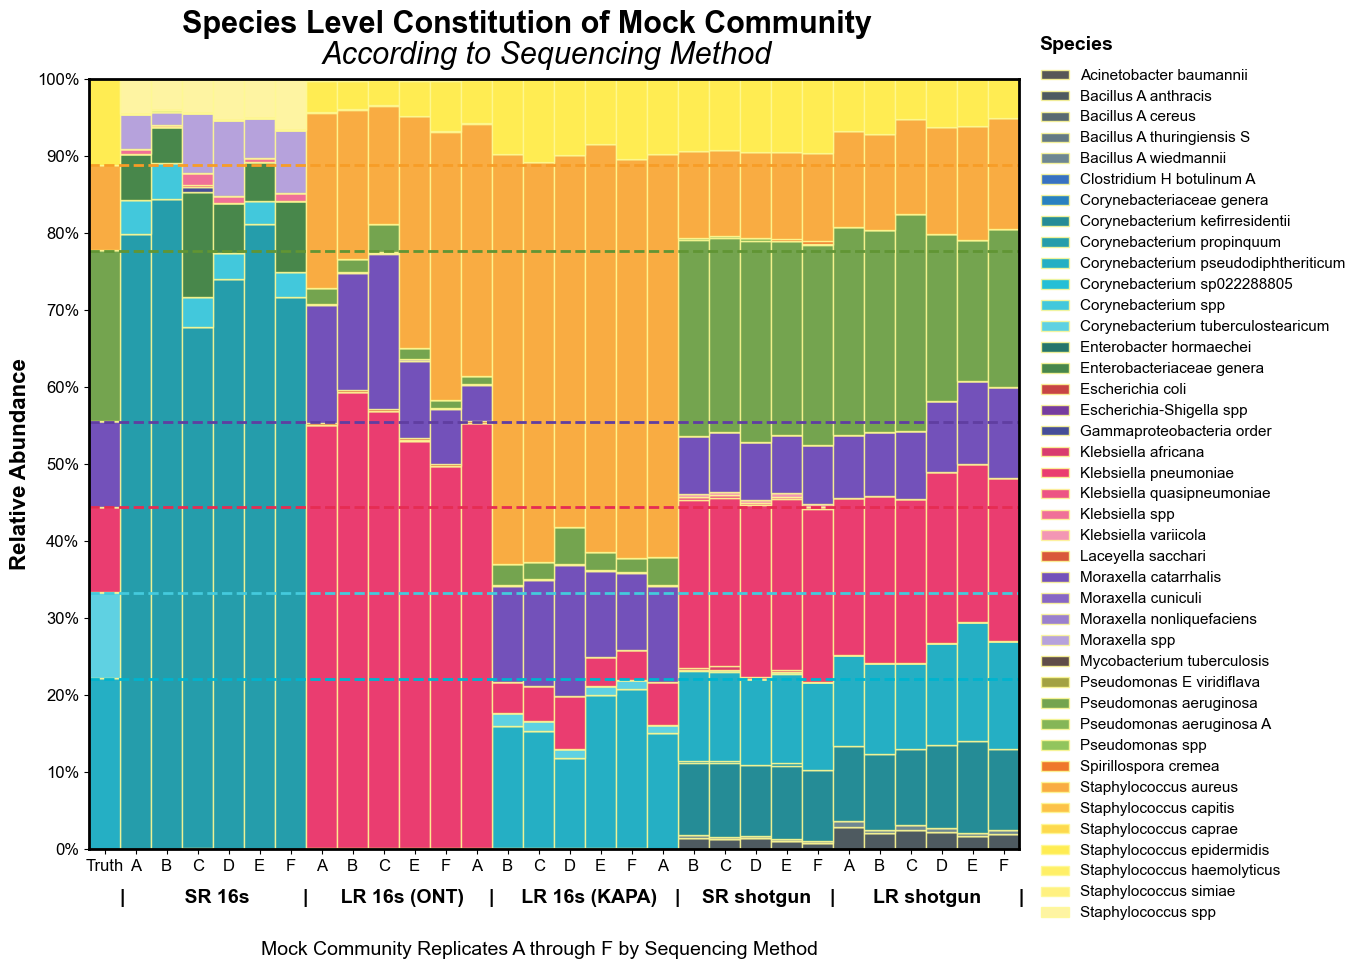

In [52]:
### PLOT SPECIES ###

labels = sorted(all_profiles_coloured['species'].unique()) #labels for legend

# colours 1
background_colour = '#D7F1FF'
plot_colour = '#FEF995'
font_colour = '#1A237E'
line_colour = '#1A237E'
plot_stackedbar_spp(transposed_spp_data, labels, species_colour_map,
                    background_colour, plot_colour, font_colour, line_colour)

# colours 2
background_colour = 'none'
plot_colour = 'whitesmoke'
font_colour = 'black'
line_colour = 'black'
plot_stackedbar_spp(transposed_spp_data, labels, species_colour_map,
                    background_colour, plot_colour, font_colour, line_colour)

# colours 3
background_colour = 'none'
plot_colour = 'none'
font_colour = 'black'
line_colour = 'black'
plot_stackedbar_spp(transposed_spp_data, labels, species_colour_map,
                    background_colour, plot_colour, font_colour, line_colour)

In [23]:
### PREPARE GENUS LEVEL DATA ###

genusDFplot = pd.DataFrame(index=unique_genera)

# name the index column "genus"
genusDFplot.index.name = "genus"

for df in high_qual_df_list:
    sample = df['sample'].unique()[0]
    # Group by genus and sum the fractions
    aggregated_df = df.groupby('genus')['fraction'].sum()
    genusDFplot[sample] = aggregated_df.reindex(genusDFplot.index, fill_value=0)

transposed_genus_data = genusDFplot.T

In [57]:
### FUNCTION TO PLOT GENUS ###

# colours 1
background_colour = '#D7F1FF'
plot_colour = '#FEF995'
font_colour = '#1A237E'
line_colour = '#1A237E'

def plot_stackedbar_genus(df, labels, color_map,
                          background_colour, plot_colour, font_colour, line_colour):
    fields = df.columns.tolist()
    
    # figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 10))
    
    # plot bars
    bottom = len(df) * [0]
    for idx, name in enumerate(fields):
        plt.bar(df.index, df[name], bottom=bottom, color=color_map[name], alpha=1, edgecolor='#FEF995', width=1, label=name)
        bottom = bottom + df[name]
    
    # legend
    plt.text(30.15, 0.99, 'Genera', fontsize=16, fontweight='bold', color=font_colour)
    legend = plt.legend(labels, bbox_to_anchor=([1.01, 0.98, 0, 0]), ncol=1, frameon=False)
    for text in legend.get_texts():
        text.set_color(font_colour)
        text.set_fontsize(11)
    
    # format y ticks
    yticks = np.arange(0, 1.1, 0.1)
    ylabels = ['{}%'.format(i) for i in np.arange(0, 101, 10)]
    plt.yticks(yticks, ylabels)

    # relabel x ticks
    plt.xticks(df.index, ["Truth", "A", "B", "C", "D", "E", "F",
               "A", "B", "C", "E", "F",
               "A", "B", "C", "D", "E", "F",
               "A", "B", "C", "D", "E", "F",
               "A", "B", "C", "D", "E", "F"])

    # # adjust limits and draw grid lines
    plt.xlim(-0.5, ax.get_xticks()[-1] + 0.5)
    plt.ylim(0, 1)

    # axes label colour and font
    ax.tick_params(axis='x', colors=line_colour)
    ax.tick_params(axis='y', colors=line_colour)

    for label in ax.get_xticklabels():
        label.set_fontsize(12)

    for label in ax.get_yticklabels():
        label.set_fontsize(12)

    # Rotate x-axis tick labels
    plt.xticks(rotation=0)

    # Grid params
    ax.set_facecolor(plot_colour)

    # Figure params
    figure = plt.gcf()
    figure.set_facecolor(background_colour)
    
    # horrizontal lines
    plt.axhline(y=0.332, color='#007884', linestyle='--', linewidth=2)
    plt.axhline(y=0.444, color='#E62C53', linestyle='--', linewidth=2)
    plt.axhline(y=0.555, color='#603EA1', linestyle='--', linewidth=2)
    plt.axhline(y=0.777, color='#619534', linestyle='--', linewidth=2)
    # vertical lines
    plt.axvline(x=0.5, color=plot_colour, linestyle='-', linewidth=3)
    plt.axvline(x=6.5, color=plot_colour, linestyle='-', linewidth=3)
    plt.axvline(x=12.5, color=plot_colour, linestyle='-', linewidth=3)
    plt.axvline(x=18.5, color=plot_colour, linestyle='-', linewidth=3)
    plt.axvline(x=23.5, color=plot_colour, linestyle='-', linewidth=3)
    ax.spines['right'].set_color(line_colour)
    ax.spines['right'].set_linewidth(2)
    ax.spines['left'].set_color(line_colour)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_color(line_colour)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_color(line_colour)
    ax.spines['bottom'].set_linewidth(2)

    # title and labels
    plt.text(3, 1.06, 'Genus Level Constitution of Mock Community', fontsize=22, fontweight='bold', color=font_colour)
    plt.text(7.5, 1.02, 'According to Sequencing Method', fontsize=22, fontstyle='italic', color=font_colour)
    figure.supxlabel('Mock Community Replicates A through F by Sequencing Method', color=font_colour, fontsize=14, y=0.005)
    ax.set_ylabel('Relative Abundance', color=font_colour, fontsize=16, fontweight='bold', labelpad=5)

    # x subtitles
    plt.text(0.5, -0.07, '|           SR 16s     ', fontsize=14, fontweight='bold', color=font_colour)
    plt.text(6.4, -0.07, '|      LR 16s (ONT)   ', fontsize=14, fontweight='bold', color=font_colour)
    plt.text(12.4, -0.07, '|     LR 16s (KAPA)  ', fontsize=14, fontweight='bold', color=font_colour)
    plt.text(18.4, -0.07, '|    SR shotgun  ', fontsize=14, fontweight='bold', color=font_colour)
    plt.text(23.4, -0.07, '|       LR shotgun       |', fontsize=14, fontweight='bold', color=font_colour)

    plt.show()

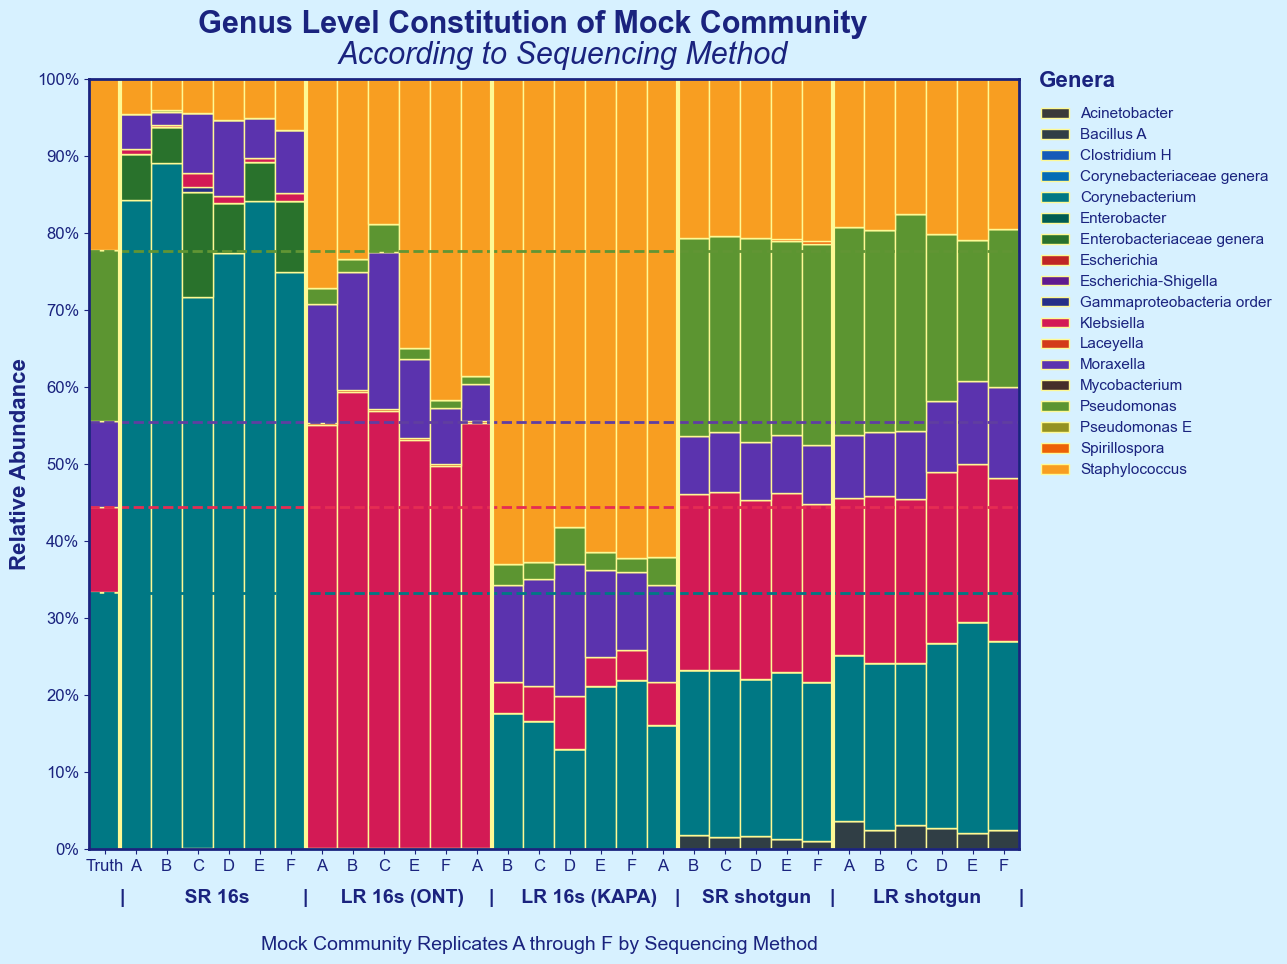

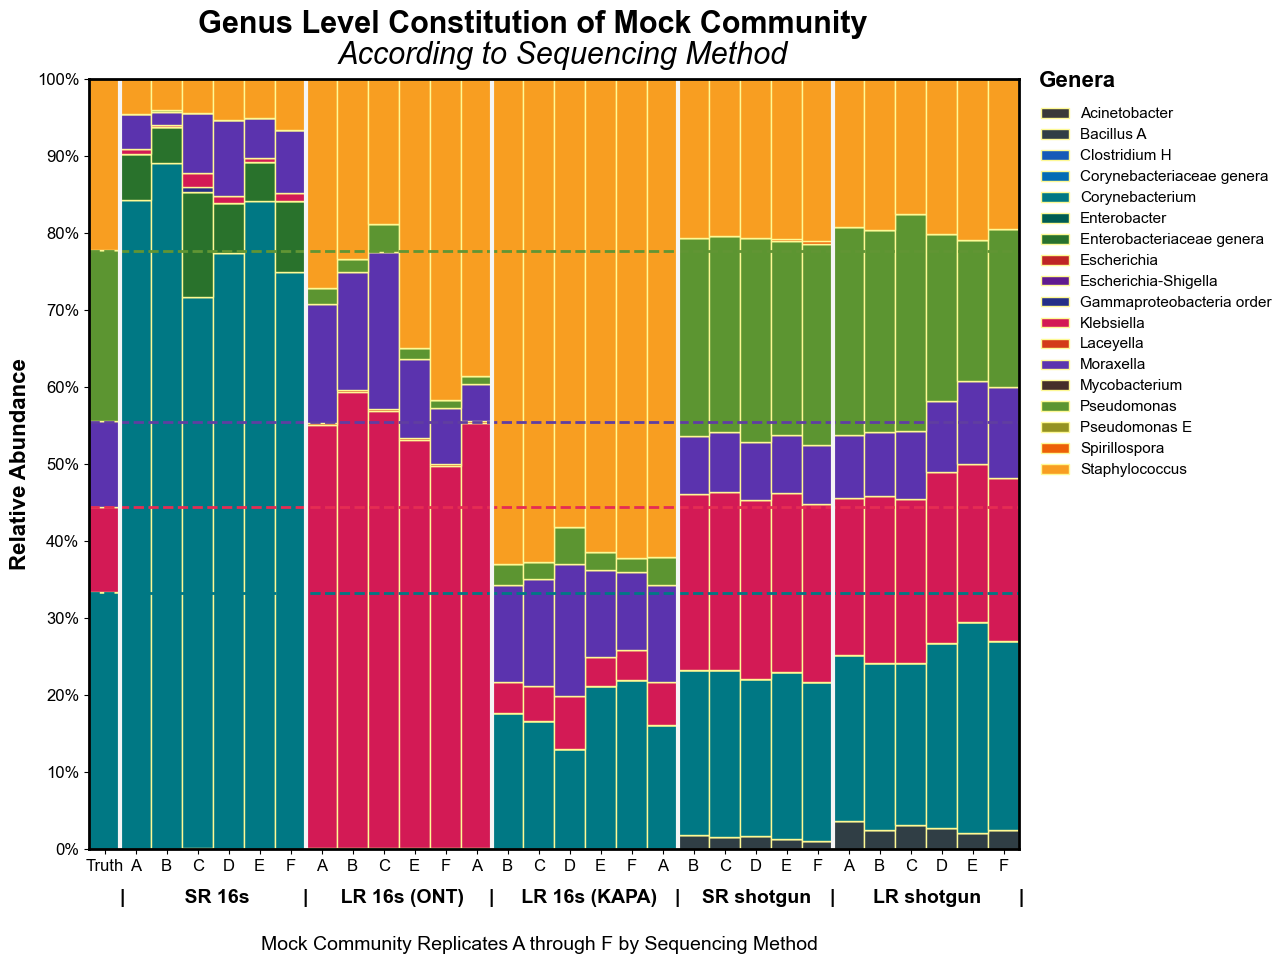

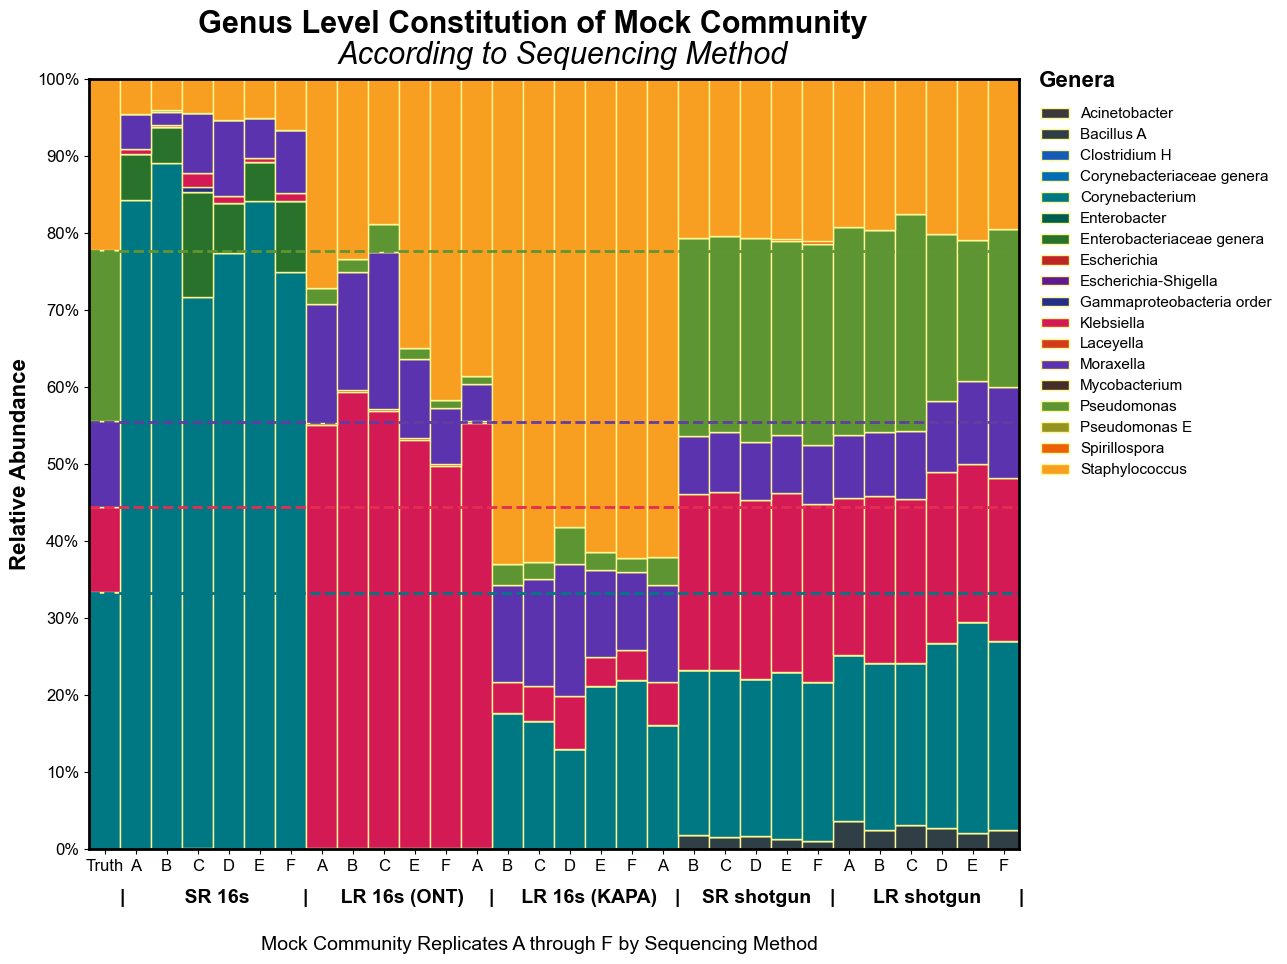

In [58]:
### PLOT GENUS ###

labels = sorted(all_profiles_coloured['genus'].unique()) #labels for legend

# colours 1
background_colour = '#D7F1FF'
plot_colour = '#FEF995'
font_colour = '#1A237E'
line_colour = '#1A237E'
plot_stackedbar_genus(transposed_genus_data, labels, genus_colour_map,
                      background_colour, plot_colour, font_colour, line_colour)

# colours 2
background_colour = 'none'
plot_colour = 'whitesmoke'
font_colour = 'black'
line_colour = 'black'
plot_stackedbar_genus(transposed_genus_data, labels, genus_colour_map,
                      background_colour, plot_colour, font_colour, line_colour)

# colours 3
background_colour = 'none'
plot_colour = 'none'
font_colour = 'black'
line_colour = 'black'
plot_stackedbar_genus(transposed_genus_data, labels, genus_colour_map,
                      background_colour, plot_colour, font_colour, line_colour)

In [26]:
# save the transposed matrices for diversity analysis
spp_countM = transposed_spp_data
genus_countM = transposed_genus_data

spp_countM.to_csv("processed_data/spp_countMatrix.csv", index=False)
genus_countM.to_csv("processed_data/genus_countMatrix.csv", index=False)

### Plot to compare data pre/post processing

In [27]:
# preprocessing df list (samples that have shot in the name)
preprocessing_df_list = []
for df in all_df_list:
    if "shot" in df['sample'].unique()[0]:
        preprocessing_df_list.append(df)

# order the df lists so its all the A_s the all the B_s etc
ordered_preprocessing_df_list = [high_qual_df_list[0]]
for i in range(6):
    for df in preprocessing_df_list:
        if df['sample'].unique()[0].startswith(f"{chr(65 + i)}"):
            ordered_preprocessing_df_list.append(df)

In [28]:
### PREPARE SPECIES LEVEL DATA ###

# Create a DataFrame with the unique species as the index
processing_sppDFplot = pd.DataFrame(index=unique_species)

# name the index column "species"
processing_sppDFplot.index.name = "species"

# iterate through each df in final_df_list, name a column after the unique value in sample, and add the fraction to the sppDFplot DataFrame for the corresponding secies in the species column
for df in ordered_preprocessing_df_list:
    sample = df['sample'].unique()[0]
    processing_sppDFplot[sample] = df.set_index('species')['fraction']

# replace NaN with 0
processing_sppDFplot.fillna(0, inplace=True)

# transpose
t_processing_spp_data = processing_sppDFplot.T

In [29]:
### FUNCTION TO PLOT SPECIES ###

def plot_stackedbar_spp(df, labels, color_map,
                        background_colour, plot_colour, font_colour, line_colour):
    fields = df.columns.tolist()
    
    # figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 10))
    
    # plot bars
    bottom = len(df) * [0]
    for idx, name in enumerate(fields):
        plt.bar(df.index, df[name], bottom=bottom, color=color_map[name], alpha=0.85, edgecolor='#FEF995', width=1, label=name)
        bottom = bottom + df[name]
    
    # legend
    plt.text(23, 1.0375, 'Species', fontsize=14, fontweight='bold', color=font_colour)
    legend = plt.legend(labels, bbox_to_anchor=([1.01, 1.03, 0, 0]), ncol=1, frameon=False)
    for text in legend.get_texts():
        text.set_color(font_colour)
        text.set_fontsize(11)
    
    # format y ticks
    yticks = np.arange(0, 1.1, 0.1)
    ylabels = ['{}%'.format(i) for i in np.arange(0, 101, 10)]
    plt.yticks(yticks, ylabels)

    # relabel x ticks
    plt.xticks(df.index, ["Ground truth", 
                "A SR high qual", "A SR low qual", "A LR high qual", "A LR low qual",
                "B SR high qual", "B SR low qual", "B LR high qual", "B LR low qual",
                "C SR high qual", "C SR low qual", "C LR high qual", "C LR low qual",
                "D LR high qual", "D LR low qual",
                "E SR high qual", "E SR low qual", "E LR high qual", "E LR low qual",
                "F SR high qual", "F SR low qual", "F LR high qual", "F LR low qual"])
    plt.xticks(rotation=90, fontweight='bold')

    # # adjust limits and draw grid lines
    plt.xlim(-0.5, ax.get_xticks()[-1] + 0.5)

    # axes label colour and font
    ax.tick_params(axis='x', colors=line_colour)
    ax.tick_params(axis='y', colors=line_colour)

    for label in ax.get_xticklabels():
        label.set_fontsize(12)

    for label in ax.get_yticklabels():
        label.set_fontsize(12)

    # Grid params
    ax.set_facecolor(plot_colour)

    # Figure params
    figure = plt.gcf()
    figure.set_facecolor(background_colour)
    
    # horrizontal lines
    plt.axhline(y=0.221, color='#18A0AD', linestyle='--', linewidth=2)
    plt.axhline(y=0.332, color='#4CC7CF', linestyle='--', linewidth=2)
    plt.axhline(y=0.444, color='#E62C53', linestyle='--', linewidth=2)
    plt.axhline(y=0.555, color='#603EA1', linestyle='--', linewidth=2)
    plt.axhline(y=0.777, color='#619534', linestyle='--', linewidth=2)
    plt.axhline(y=0.888, color='#F79D27', linestyle='--', linewidth=2)
    ax.spines['right'].set_color(line_colour)
    ax.spines['right'].set_linewidth(2)
    ax.spines['left'].set_color(line_colour)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_color(line_colour)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_color(line_colour)
    ax.spines['bottom'].set_linewidth(2)

    # title and labels
    plt.text(0, 1.085, 'Species Level: Change in SR and LR Taxonomic Profiles', fontsize=22, fontweight='bold', color=font_colour)
    plt.text(6, 1.03, 'Before and After Processing', fontsize=22, color=font_colour)
    ax.set_ylabel('Relative Abundance', color=font_colour, fontsize=16, fontweight='bold', labelpad=5)

    plt.show()

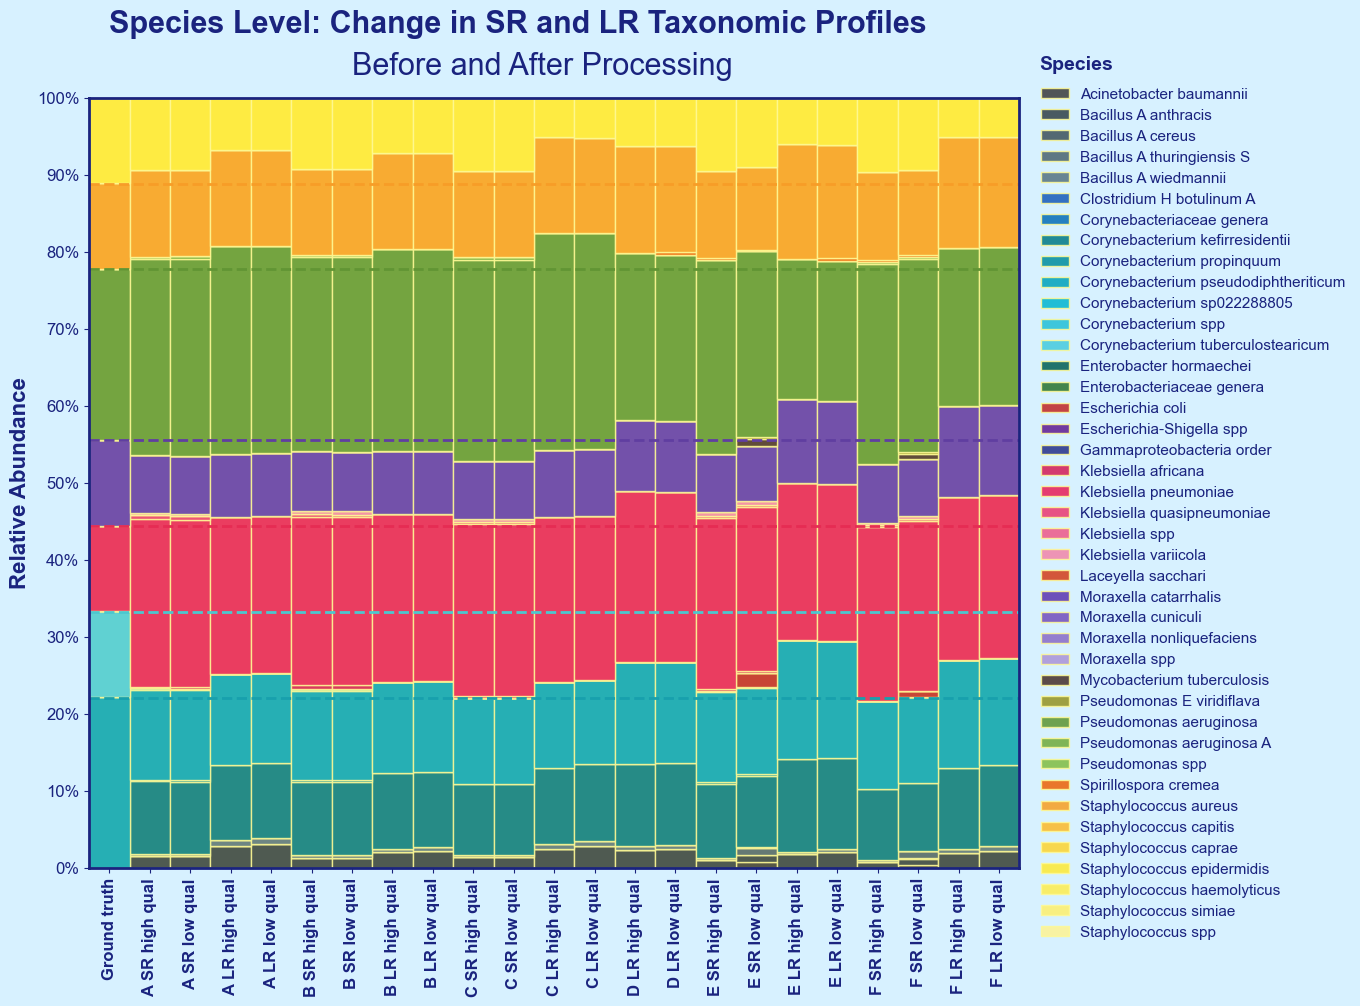

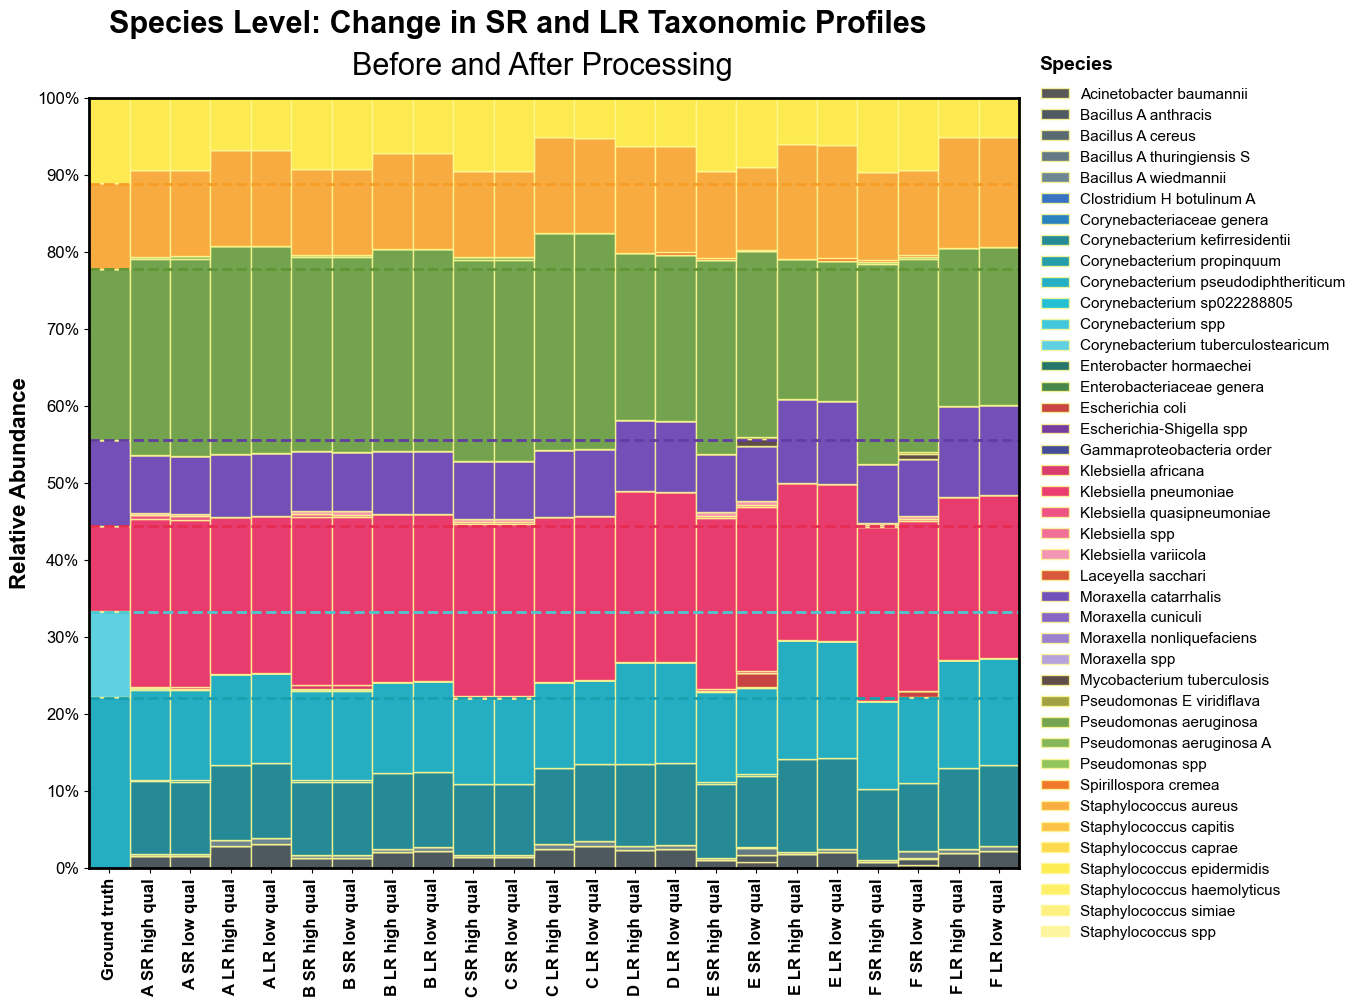

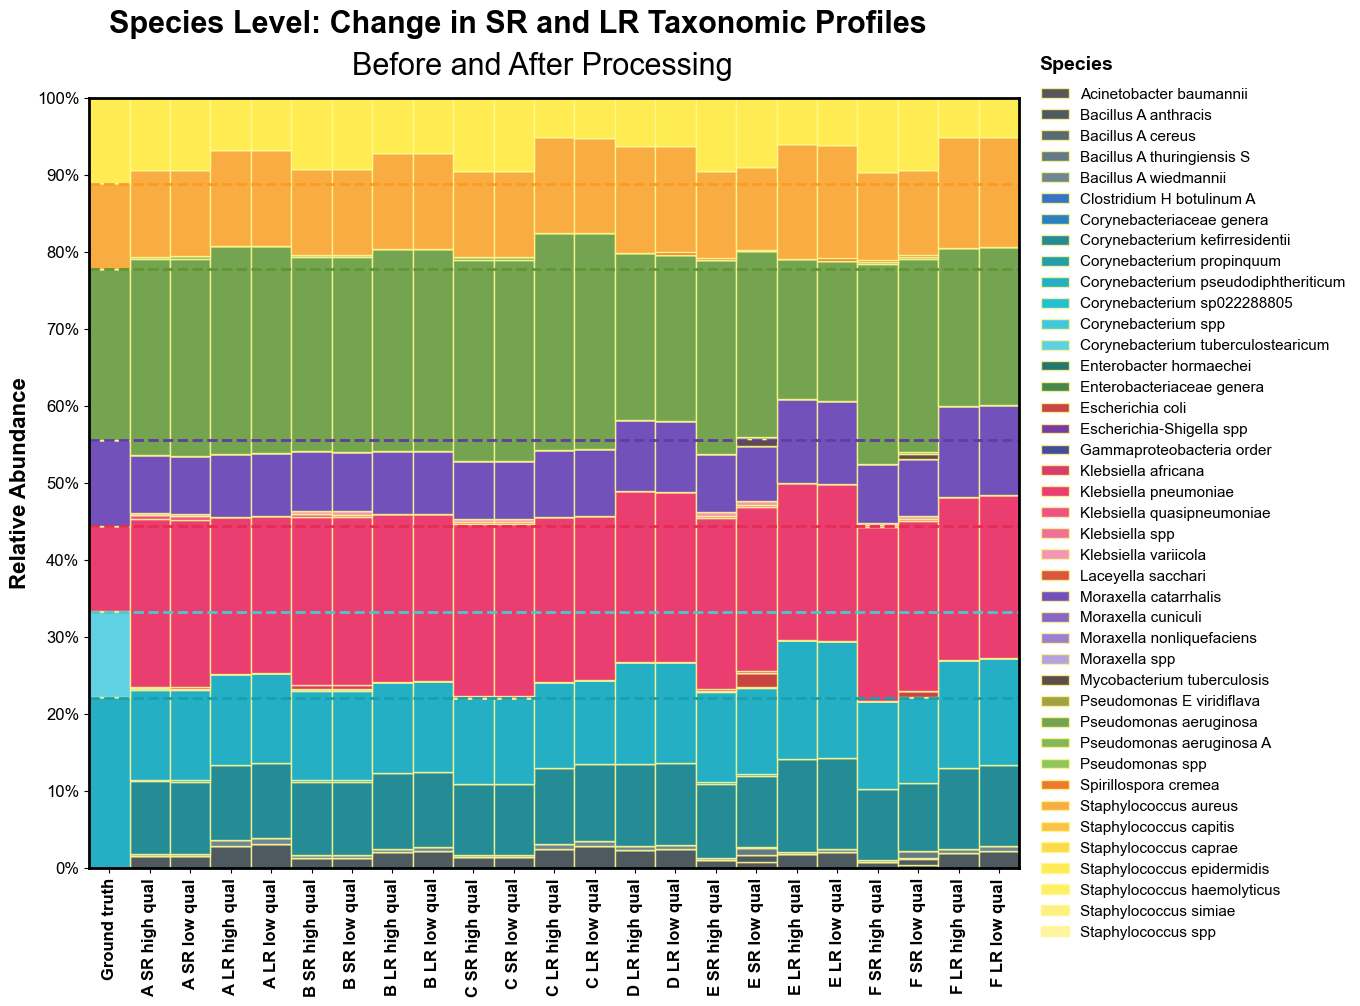

In [30]:
### PLOT SPECIES ###

# Assuming all_mocks_coloured is your DataFrame
labels = sorted(all_profiles_coloured['species'].unique()) #labels for legend

# colours 1
background_colour = '#D7F1FF'
plot_colour = '#FEF995'
font_colour = '#1A237E'
line_colour = '#1A237E'
plot_stackedbar_spp(t_processing_spp_data, labels, species_colour_map,
                    background_colour, plot_colour, font_colour, line_colour)

# colours 2
background_colour = 'none'
plot_colour = 'whitesmoke'
font_colour = 'black'
line_colour = 'black'
plot_stackedbar_spp(t_processing_spp_data, labels, species_colour_map,
                    background_colour, plot_colour, font_colour, line_colour)

# colours 3
background_colour = 'none'
plot_colour = 'none'
font_colour = 'black'
line_colour = 'black'
plot_stackedbar_spp(t_processing_spp_data, labels, species_colour_map,
                    background_colour, plot_colour, font_colour, line_colour)

In [31]:
### PREPARE GENUS LEVEL DATA ###

processing_genusDFplot = pd.DataFrame(index=unique_genera)

# name the index column "genus"
processing_genusDFplot.index.name = "genus"

for df in ordered_preprocessing_df_list:
    sample = df['sample'].unique()[0]
    # Group by genus and sum the fractions
    aggregated_df = df.groupby('genus')['fraction'].sum()
    processing_genusDFplot[sample] = aggregated_df.reindex(genusDFplot.index, fill_value=0)

t_processing_genus_data = processing_genusDFplot.T

In [32]:
### FUNCTION TO PLOT GENUS ###

def plot_stackedbar_genus(df, labels, color_map,
                          background_colour, plot_colour, font_colour, line_colour):
    fields = df.columns.tolist()
    
    # figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 10))
    
    # plot bars
    bottom = len(df) * [0]
    for idx, name in enumerate(fields):
        plt.bar(df.index, df[name], bottom=bottom, color=color_map[name], alpha=1, edgecolor='#FEF995', width=1, label=name)
        bottom = bottom + df[name]
    
    # legend
    plt.text(23, 0.99, 'Genera', fontsize=16, fontweight='bold', color=font_colour)
    legend = plt.legend(labels, bbox_to_anchor=([1.01, 0.98, 0, 0]), ncol=1, frameon=False)
    for text in legend.get_texts():
        text.set_color(font_colour)
        text.set_fontsize(11)
    
    # format y ticks
    yticks = np.arange(0, 1.1, 0.1)
    ylabels = ['{}%'.format(i) for i in np.arange(0, 101, 10)]
    plt.yticks(yticks, ylabels)

    # relabel x ticks
    plt.xticks(df.index, ["Ground truth", 
                "A SR high qual", "A SR low qual", "A LR high qual", "A LR low qual",
                "B SR high qual", "B SR low qual", "B LR high qual", "B LR low qual",
                "C SR high qual", "C SR low qual", "C LR high qual", "C LR low qual",
                "D LR high qual", "D LR low qual",
                "E SR high qual", "E SR low qual", "E LR high qual", "E LR low qual",
                "F SR high qual", "F SR low qual", "F LR high qual", "F LR low qual"])
    plt.xticks(rotation=90, fontweight='bold')

    # # adjust limits and draw grid lines
    plt.xlim(-0.5, ax.get_xticks()[-1] + 0.5)
    plt.ylim(0, 1)

    # axes label colour and font
    ax.tick_params(axis='x', colors=line_colour)
    ax.tick_params(axis='y', colors=line_colour)

    for label in ax.get_xticklabels():
        label.set_fontsize(12)

    for label in ax.get_yticklabels():
        label.set_fontsize(12)

    # Grid params
    ax.set_facecolor(plot_colour)

    # Figure params
    figure = plt.gcf()
    figure.set_facecolor(background_colour)
    
    # horrizontal lines
    plt.axhline(y=0.332, color='#4CC7CF', linestyle='--', linewidth=2)
    plt.axhline(y=0.444, color='#E62C53', linestyle='--', linewidth=2)
    plt.axhline(y=0.555, color='#603EA1', linestyle='--', linewidth=2)
    plt.axhline(y=0.777, color='#619534', linestyle='--', linewidth=2)
    # vertical lines
    ax.spines['right'].set_color(line_colour)
    ax.spines['right'].set_linewidth(2)
    ax.spines['left'].set_color(line_colour)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_color(line_colour)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_color(line_colour)
    ax.spines['bottom'].set_linewidth(2)

    # title and labels
    plt.text(0, 1.085, 'Genus Level: Change in SR and LR Taxonomic Profiles', fontsize=22, fontweight='bold', color=font_colour)
    plt.text(6, 1.03, 'Before and After Processing', fontsize=22, color=font_colour)
    ax.set_ylabel('Relative Abundance', color=font_colour, fontsize=16, fontweight='bold', labelpad=5)

    plt.show()

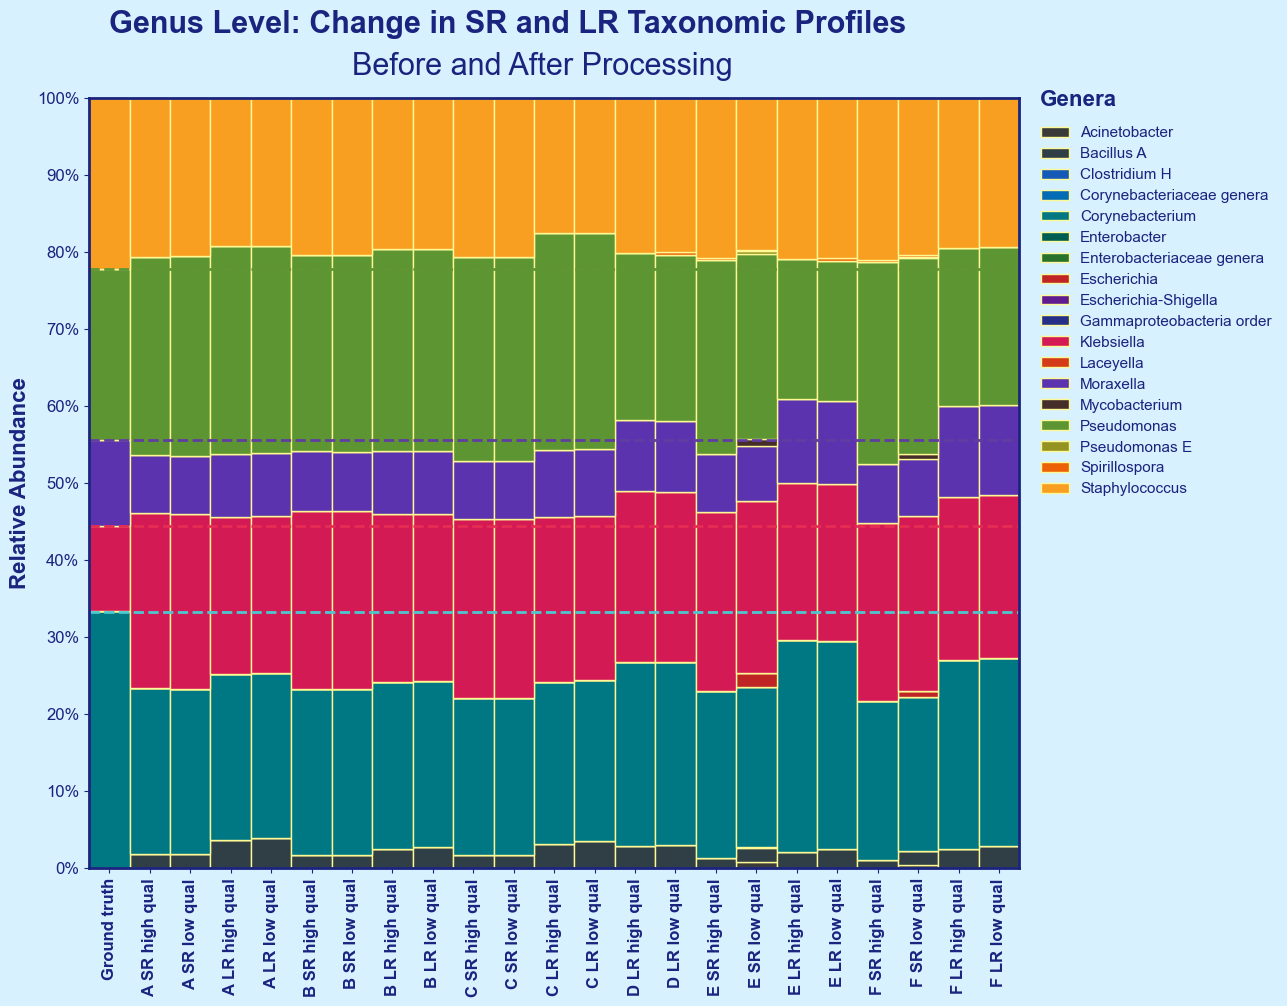

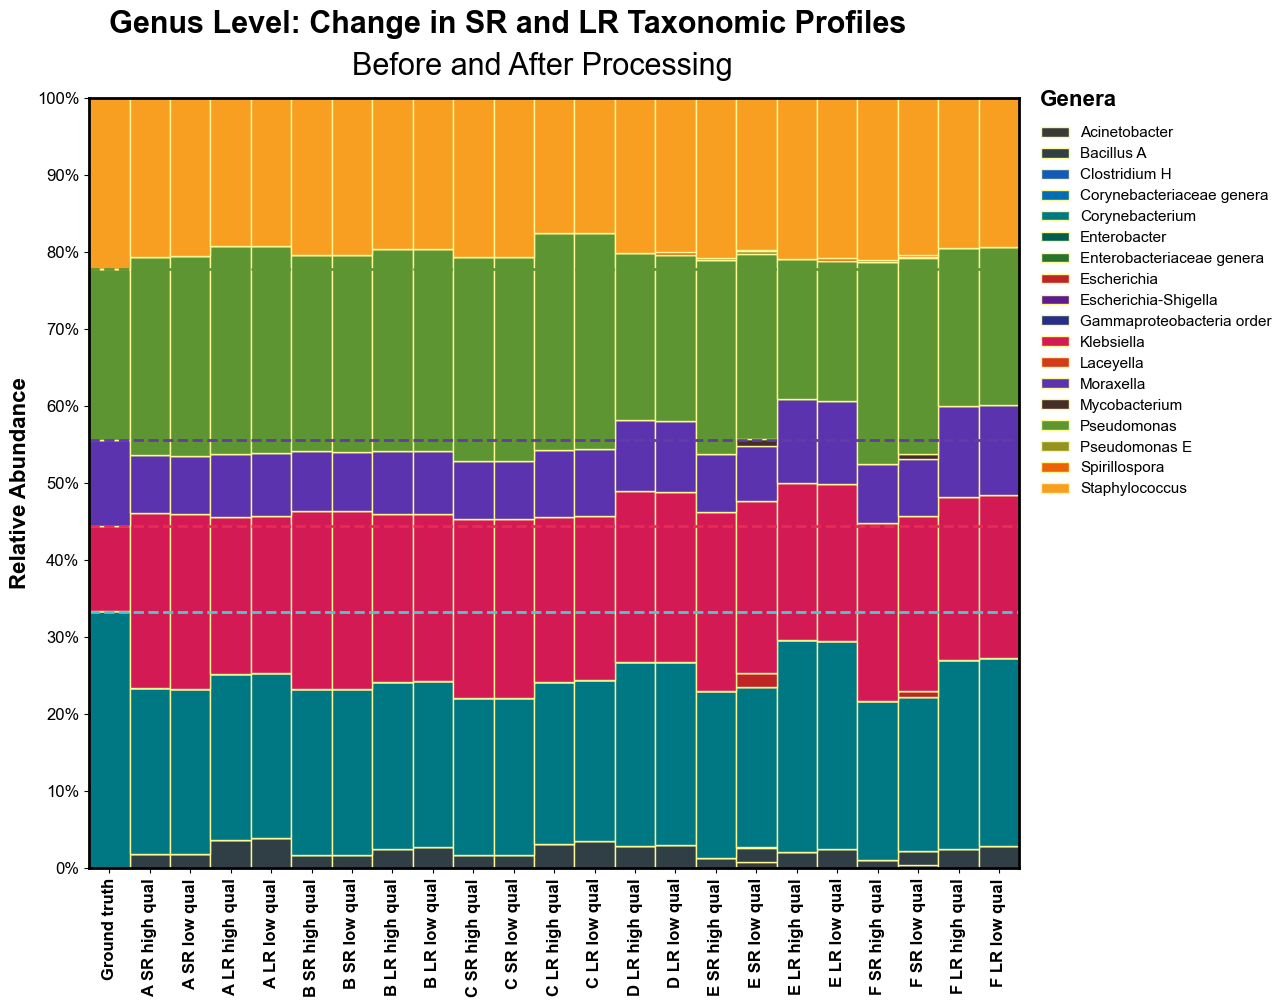

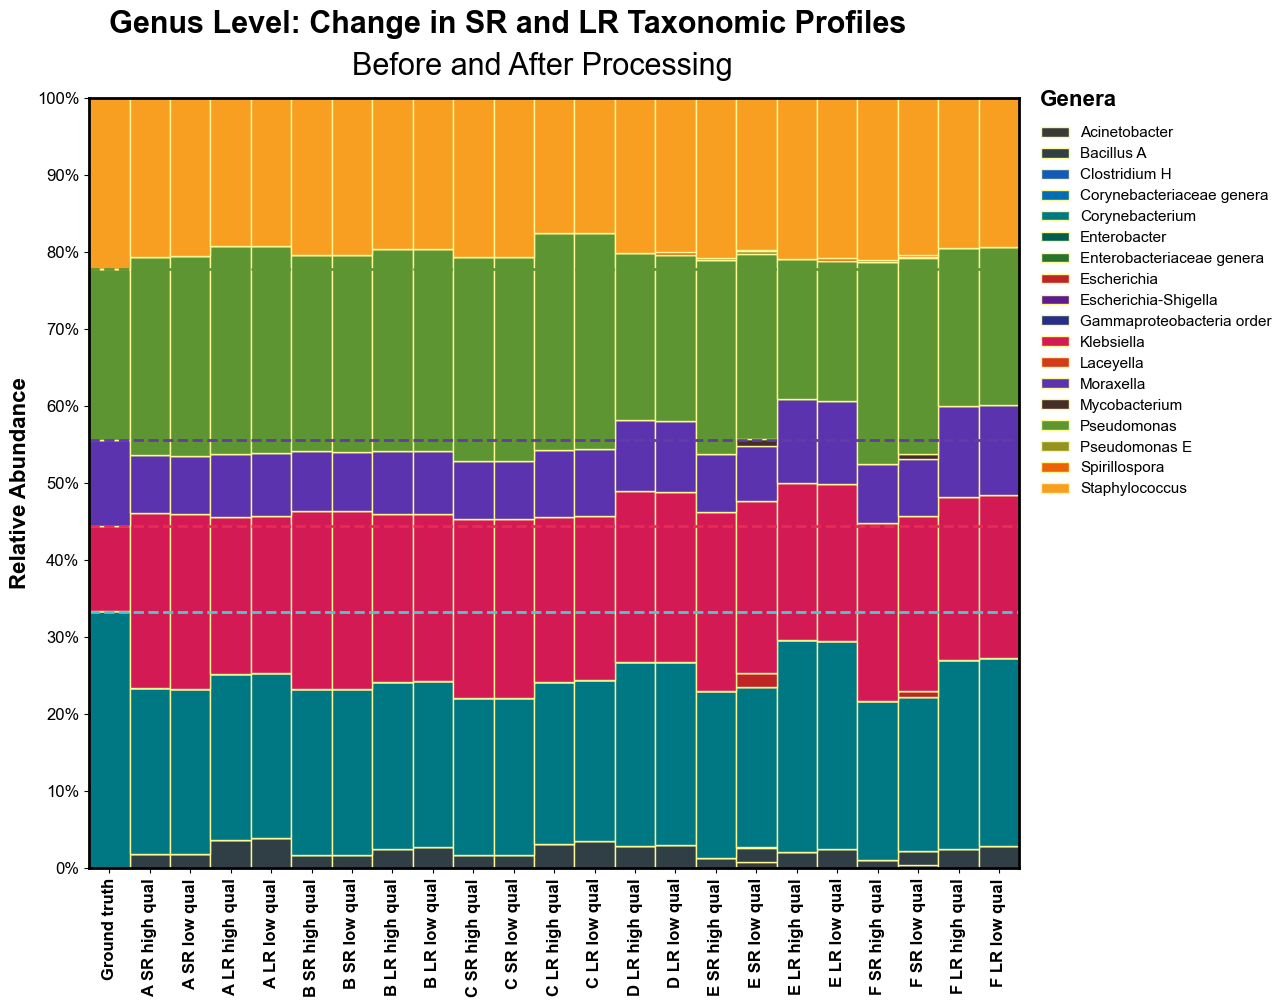

In [33]:
labels = sorted(all_profiles_coloured['genus'].unique()) #labels for legend

# colours 1
background_colour = '#D7F1FF'
plot_colour = '#FEF995'
font_colour = '#1A237E'
line_colour = '#1A237E'
plot_stackedbar_genus(t_processing_genus_data, labels, genus_colour_map,
                      background_colour, plot_colour, font_colour, line_colour)

# colours 2
background_colour = 'none'
plot_colour = 'whitesmoke'
font_colour = 'black'
line_colour = 'black'
plot_stackedbar_genus(t_processing_genus_data, labels, genus_colour_map,
                      background_colour, plot_colour, font_colour, line_colour)

# colours 3
background_colour = 'none'
plot_colour = 'none'
font_colour = 'black'
line_colour = 'black'
plot_stackedbar_genus(t_processing_genus_data, labels, genus_colour_map,
                      background_colour, plot_colour, font_colour, line_colour)

In [34]:
# save the transposed matrices for diversity analysis
spp_countM = t_processing_spp_data
genus_countM = t_processing_genus_data

spp_countM.to_csv("processed_data/spp_countMatrix_processing.csv", index=False)
genus_countM.to_csv("processed_data/genus_countMatrix_processing.csv", index=False)